# Using pyRTE

## Overview

PyRTE-RRTMGP provides a flexible and efficient framework for computing radiative fluxes in planetary atmospheres. This example shows an end-to-end problem with both clear skies and clouds.

To use RTE and RRTMGP you'll need to:

1. Load data for cloud and gas optics 

Each calculation requires 

2. Computing gas and cloud optical properties and combining them to produce an all-sky problem
3. Solving the radiative transfer equation to obtain upward and downward fluxes

The package leverages `xarray` to represent data. Input data sets to the cloud and gas optics functions need to have specific datasets and specific dimensions. 

This example demonstrates the workflow for both longwave and shortwave radiative transfer calculations.

See the [documentation](https://pyrte-rrtmgp.readthedocs.io/en/latest/) for more information.

# Initialization

## Plotting - off by default 

In [1]:
do_plots = False

## Import dependencies

In [2]:
%matplotlib inline

from dask.diagnostics import ProgressBar
import xarray as xr

if do_plots: import matplotlib.pyplot as plt

## Import pyRTE entitites 

(The organization is a work in progress) 

In [3]:
from pyrte_rrtmgp import rrtmgp_cloud_optics, rrtmgp_gas_optics
from pyrte_rrtmgp.data_types import (
    CloudOpticsFiles,
    GasOpticsFiles,
    OpticsProblemTypes,
)
from pyrte_rrtmgp.rte_solver import rte_solve
from pyrte_rrtmgp.examples import (
    compute_clouds,
    compute_profiles,
    ALLSKY_EXAMPLES,
    load_example_file,
)

## Initialize gas and cloud optics 

In [4]:
cloud_optics_lw = rrtmgp_cloud_optics.load_cloud_optics(
    cloud_optics_file=CloudOpticsFiles.LW_BND
)
gas_optics_lw = rrtmgp_gas_optics.load_gas_optics(
    gas_optics_file=GasOpticsFiles.LW_G256
)

cloud_optics_sw = rrtmgp_cloud_optics.load_cloud_optics(
    cloud_optics_file=CloudOpticsFiles.SW_BND
)
gas_optics_sw = rrtmgp_gas_optics.load_gas_optics(
    gas_optics_file=GasOpticsFiles.SW_G224
)

The optics classes are `xarray Datasets` but the underlying data isn't meant to be accessed directly.

In [5]:
cloud_optics_lw, gas_optics_lw

(<xarray.Dataset> Size: 14kB
 Dimensions:                (nrghice: 3, nband: 16, nsize_ice: 18,
                             nsize_liq: 20, pair: 2)
 Dimensions without coordinates: nrghice, nband, nsize_ice, nsize_liq, pair
 Data variables:
     asyice                 (nrghice, nband, nsize_ice) float32 3kB 0.413 ... ...
     asyliq                 (nband, nsize_liq) float32 1kB 0.04438 ... 0.9175
     extice                 (nrghice, nband, nsize_ice) float32 3kB 0.0749 ......
     extliq                 (nband, nsize_liq) float32 1kB 0.0705 ... 0.07606
     bnd_limits_wavenumber  (nband, pair) float32 128B 10.0 250.0 ... 3.25e+03
     ssaice                 (nrghice, nband, nsize_ice) float32 3kB 0.214 ... ...
     ssaliq                 (nband, nsize_liq) float32 1kB 0.02628 ... 0.6133
     diamice_lwr            float32 4B 10.0
     diamice_upr            float32 4B 180.0
     radliq_lwr             float32 4B 2.5
     radliq_upr             float32 4B 21.5
 Attributes:
     NCO: 

# Create an idealized problem 

## Temperature, humidity, composition

The routine `compute_profiles()` packaged with `pyRTE_RRTMGP` computes temperature, pressure, and humidity profiles following a moist adibat. The concentrations of other gases are also needed.

In [7]:
def make_profiles(ncol=24, nlay=72):
    # Create atmospheric profiles and gas concentrations
    atmosphere = compute_profiles(300, ncol, nlay)

    # Add other gas values
    gas_values = {
        "co2": 348e-6,
        "ch4": 1650e-9,
        "n2o": 306e-9,
        "n2": 0.7808,
        "o2": 0.2095,
        "co": 0.0,
    }

    for gas_name, value in gas_values.items():
        atmosphere[gas_name] = value

    return atmosphere


atmosphere = make_profiles()

The dataset produced by `make_profiles` variable contains the minimum amount of information needed to compute clear-sky optical properties: 
- vertical dimensions `layer` and `level` with one more `level` than `layer`
- values of pressure and temperature on both vertical coordinates
- a surface temperature (for longwave problems)
- concentrations of seven gases defined on layers

In [8]:
atmosphere

<xarray.Dataset> Size: 84kB
Dimensions:              (site: 24, layer: 72, level: 73)
Dimensions without coordinates: site, layer, level
Data variables: (12/13)
    pres_layer           (site, layer) float64 14kB 9.883e+04 ... 1.213
    temp_layer           (site, layer) float64 14kB 298.6 295.9 ... 200.6 200.6
    pres_level           (site, level) float64 14kB 1.015e+05 ... 1.065
    temp_level           (site, level) float64 14kB 300.0 297.2 ... 200.6 200.6
    surface_temperature  (site) int64 192B 300 300 300 300 ... 300 300 300 300
    h2o                  (site, layer) float64 14kB 0.01768 0.01583 ... 1e-08
    ...                   ...
    co2                  float64 8B 0.000348
    ch4                  float64 8B 1.65e-06
    n2o                  float64 8B 3.06e-07
    n2                   float64 8B 0.7808
    o2                   float64 8B 0.2095
    co                   float64 8B 0.0
Attributes:
    description:  Atmospheric profiles following RCEMIP protocol
    sst:          300
    ncol:         24
    nlay:         72

## Clouds 

`compute_clouds()` adds clouds (liquid and ice water path, liquid radius and ice diameter) to 2/3 of the columns 

In [9]:
#
# Temporary workaround - compute_clouds() needs to know the particle size;
#   that's set as the mid-point of the valid range from cloud_optics
#
cloud_props = compute_clouds(
    cloud_optics_lw, atmosphere["pres_layer"], atmosphere["temp_layer"]
)

atmosphere = atmosphere.merge(cloud_props)
atmosphere

<xarray.Dataset> Size: 139kB
Dimensions:              (site: 24, layer: 72, level: 73)
Dimensions without coordinates: site, layer, level
Data variables: (12/17)
    pres_layer           (site, layer) float64 14kB 9.883e+04 ... 1.213
    temp_layer           (site, layer) float64 14kB 298.6 295.9 ... 200.6 200.6
    pres_level           (site, level) float64 14kB 1.015e+05 ... 1.065
    temp_level           (site, level) float64 14kB 300.0 297.2 ... 200.6 200.6
    surface_temperature  (site) int64 192B 300 300 300 300 ... 300 300 300 300
    h2o                  (site, layer) float64 14kB 0.01768 0.01583 ... 1e-08
    ...                   ...
    o2                   float64 8B 0.2095
    co                   float64 8B 0.0
    lwp                  (site, layer) float64 14kB 0.0 0.0 10.0 ... 0.0 0.0 0.0
    iwp                  (site, layer) float64 14kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rel                  (site, layer) float64 14kB 0.0 0.0 12.0 ... 0.0 0.0 0.0
    rei                  (site, layer) float64 14kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:  Atmospheric profiles following RCEMIP protocol
    sst:          300
    ncol:         24
    nlay:         72

# Longwave fluxes

Taking one step at a time... First we will compute the optical properties of the gases (clear skies). 

## Clear-sky fluxes

In [10]:
optical_props = gas_optics_lw.compute_gas_optics(
    atmosphere, 
    problem_type=OpticsProblemTypes.ABSORPTION, 
    add_to_input=False,
)

The optical property for absorption/emission problems is optical depth `tau` which has a spectral dimension (`gpt`). The gas optics calculation also provides the radiation source functions, which for a longwave problem is the Planck function at the layer, level, and surface temperatures. 

In [11]:
optical_props

<xarray.Dataset> Size: 11MB
Dimensions:                  (site: 24, gpt: 256, layer: 72, level: 73,
                              bnd: 16, pair: 2)
Coordinates:
  * site                     (site) int64 192B 0 1 2 3 4 5 ... 18 19 20 21 22 23
  * gpt                      (gpt) int64 2kB 0 1 2 3 4 5 ... 251 252 253 254 255
Dimensions without coordinates: layer, level, bnd, pair
Data variables:
    surface_source           (gpt, site) float64 49kB 0.6522 ... 3.006e-06
    layer_source             (layer, gpt, site) float64 4MB 0.6477 ... 4.661e-09
    level_source             (level, gpt, site) float64 4MB 0.6522 ... 4.661e-09
    surface_source_jacobian  (gpt, site) float64 49kB 0.003262 ... 1.407e-07
    tau                      (layer, gpt, site) float64 4MB 40.04 ... 0.002916
    bnd_limits_gpt           (bnd, pair) int32 128B 1 16 17 32 ... 240 241 256
Attributes:
    problem_type:     Longwave absorption
    top_at_1:         False
    dataset_mapping:  {"dim_mapping": {"site": "site", "layer": "layer", "lev...

Apply the boundary conditions:

In [12]:
optical_props["surface_emissivity"] = 0.98

Dataset `optical_props` now contains a complete description of a longwave radiative transfer problem: 
- optical properties (`tau` for problem without scattering)
- radiation sources (`layer_source`, `level_source`, and `surface_source` for problems with internal emission)
- boundary conditions (`surface_emissivity` for problems with internal emission)
These variables are `spectrally-resolved` i.e. they have a `gpt` dimension

So we can compute fluxes (spectrally-integrated by default) 

In [13]:
clr_fluxes = rte_solve(optical_props, add_to_input=False)
clr_fluxes

<xarray.Dataset> Size: 28kB
Dimensions:       (site: 24, level: 73)
Coordinates:
  * site          (site) int64 192B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Dimensions without coordinates: level
Data variables:
    lw_flux_up    (site, level) float64 14kB 457.6 448.7 438.4 ... 277.4 277.4
    lw_flux_down  (site, level) float64 14kB 376.1 351.8 329.3 ... 0.01084 0.0

What do the fluxes look like? They're the same in every column so plot just the first.

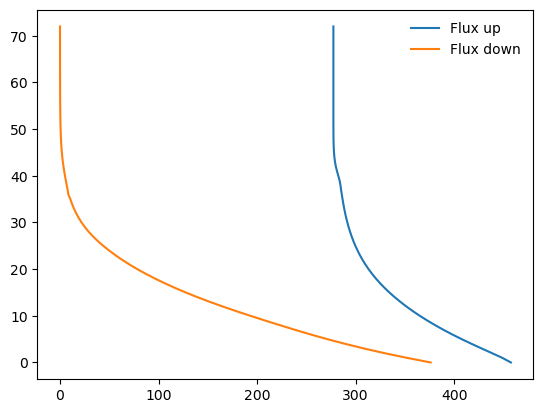

In [14]:
if do_plots:
    plt.plot(clr_fluxes.lw_flux_up.isel(site=0),   clr_fluxes.level, label="Flux up")
    plt.plot(clr_fluxes.lw_flux_down.isel(site=0), clr_fluxes.level, label="Flux down")
    plt.legend(frameon=False)

## Cloudy-sky fluxes

Next compute the optical properties of the clouds. Because we're treating absorption the only output is `tau`. The source functions aren't returned because the temperature isn't known. 

In [15]:
clouds_optical_props = cloud_optics_lw.compute_cloud_optics(
    atmosphere, problem_type=OpticsProblemTypes.ABSORPTION
)
# The optical properties of the clouds alone
clouds_optical_props

<xarray.Dataset> Size: 221kB
Dimensions:  (site: 24, layer: 72, bnd: 16)
Coordinates:
  * site     (site) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: layer, bnd
Data variables:
    tau      (layer, bnd, site) float64 221kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    dataset_mapping:  {"dim_mapping": {"site": "site", "layer": "layer", "lev...

Next compute the combined optical properties of the clouds and gases with `add_to()`, which updates the optical properties in its argument.

In [16]:
# add_to() changes the value of `optical_props`
clouds_optical_props.add_to(optical_props)
optical_props

<xarray.Dataset> Size: 11MB
Dimensions:                  (site: 24, gpt: 256, layer: 72, level: 73,
                              bnd: 16, pair: 2)
Coordinates:
  * site                     (site) int64 192B 0 1 2 3 4 5 ... 18 19 20 21 22 23
  * gpt                      (gpt) int64 2kB 0 1 2 3 4 5 ... 251 252 253 254 255
Dimensions without coordinates: layer, level, bnd, pair
Data variables:
    surface_source           (gpt, site) float64 49kB 0.6522 ... 3.006e-06
    layer_source             (layer, gpt, site) float64 4MB 0.6477 ... 4.661e-09
    level_source             (level, gpt, site) float64 4MB 0.6522 ... 4.661e-09
    surface_source_jacobian  (gpt, site) float64 49kB 0.003262 ... 1.407e-07
    tau                      (layer, gpt, site) float64 4MB 40.04 ... 0.002916
    bnd_limits_gpt           (bnd, pair) int32 128B 1 16 17 32 ... 240 241 256
    surface_emissivity       float64 8B 0.98
Attributes:
    problem_type:     Longwave absorption
    top_at_1:         False
    dataset_mapping:  {"dim_mapping": {"site": "site", "layer": "layer", "lev...

In [17]:
fluxes = rte_solve(optical_props, add_to_input=False)

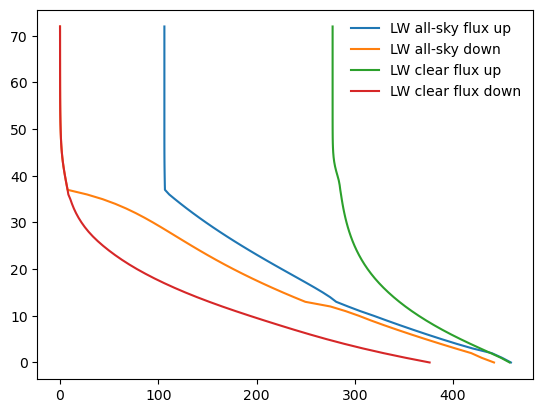

In [18]:
if do_plots:
    plt.plot(fluxes.lw_flux_up.isel  (site=0), fluxes.level, label="LW all-sky flux up")
    plt.plot(fluxes.lw_flux_down.isel(site=0), fluxes.level, label="LW all-sky down")
    plt.plot(fluxes.lw_flux_up.isel  (site=2), fluxes.level, label="LW clear flux up")
    plt.plot(fluxes.lw_flux_down.isel(site=2), fluxes.level, label="LW clear flux down")
    plt.legend(frameon=False)

# Shortwave fluxes

Shortwave problems require different sets of optical properties, source, and boundary conditions. The first two 
are provided by the shortwave gas optics, as you'll see. 
Python allows intermediate steps to be combined. For example we can compute the all-sky optical properties directly by combining
the `gas_optics()`, `cloud_optics()`, and `add_to()` steps:

In [19]:
# add_to() also returns updated optical properties 
optical_props = cloud_optics_sw.compute_cloud_optics(atmosphere).add_to(
    gas_optics_sw.compute_gas_optics(
        atmosphere, 
        problem_type=OpticsProblemTypes.TWO_STREAM, 
        add_to_input=False,
    ), 
    delta_scale=True,
)

(Delta scaling increases accuracy for clouds, which have strong forward scattering (large `g`)).

Dataset `optical_props` now contains a nearly-complete description of a shortwave radiative transfer problem: 
- optical properties (`tau`, `ssa`, and `g` define a two-stream problem)
- radiation source (`toa_source`, `level_source`, and `surface_source` for the incoming sunlight as a collimated beam)
These variables are `spectrally-resolved` i.e. they have a `gpt` dimension

In [20]:
optical_props

<xarray.Dataset> Size: 9MB
Dimensions:         (site: 24, gpt: 224, layer: 72, bnd: 14, pair: 2)
Coordinates:
  * site            (site) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Dimensions without coordinates: gpt, layer, bnd, pair
Data variables:
    toa_source      (site, gpt) float64 43kB 1.994 1.938 ... 0.004777 0.001233
    tau             (layer, gpt, site) float64 3MB 0.02873 0.02873 ... 0.0001194
    ssa             (layer, gpt, site) float64 3MB 5.438e-05 ... 0.1774
    g               (layer, gpt, site) float64 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bnd_limits_gpt  (bnd, pair) int32 112B 1 16 17 32 33 ... 192 193 208 209 224
Attributes:
    problem_type:     Shortwave 2-stream
    top_at_1:         False
    dataset_mapping:  {"dim_mapping": {"site": "site", "layer": "layer", "lev...

To compute fluxes the boundary condition needs to specified by supplying `surface_albedo` or the respective albedos for direct and diffuse radiation (`surface_albedo_direct`, `surface_albedo_diffuse`) as well as the cosine of the incident solar zenith angle `mu0`. 


In [21]:
optical_props["surface_albedo"] = 0.06
optical_props["mu0"] = 0.86
fluxes = rte_solve(optical_props, add_to_input=False)

The returned fluxes include the total downwelling (`sw_flux_down`) and the direct beam component of that flux (`sw_flux_dir`) 

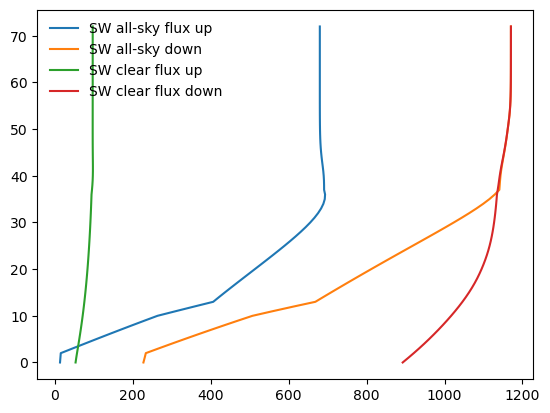

In [22]:
if do_plots:
    plt.plot(fluxes.sw_flux_up.isel  (site=0), fluxes.level, label="SW all-sky flux up")
    plt.plot(fluxes.sw_flux_down.isel(site=0), fluxes.level, label="SW all-sky down")
    plt.plot(fluxes.sw_flux_up.isel  (site=2), fluxes.level, label="SW clear flux up")
    plt.plot(fluxes.sw_flux_down.isel(site=2), fluxes.level, label="SW clear flux down")
    plt.legend(frameon=False)

## Variants 

### Combining steps
The computation of optical properties and fluxes can be combined:

In [23]:
fluxes = rte_solve(
    xr.merge(
        [cloud_optics_sw.compute_cloud_optics(atmosphere).add_to(
            gas_optics_sw.compute_gas_optics(
                atmosphere, 
                problem_type=OpticsProblemTypes.TWO_STREAM, 
                add_to_input=False,
            ), 
            delta_scale=True,
        ), 
        xr.Dataset(data_vars = {"surface_albedo":0.06, "mu0":0.86})],
    ), 
    add_to_input = False,
)

# ### Parallelization with dask
# Calculations can be divided and performed in parallel using `dask` using dask arrays. The only restriction is that 
# vertical dimensions can't be chuncked over  

In [24]:
atmosphere = make_profiles(ncol=24*16)
cloud_props = compute_clouds(
    cloud_optics_lw, atmosphere["pres_layer"], atmosphere["temp_layer"]
)

atmosphere = atmosphere.merge(cloud_props).chunk({"site":16})
atmosphere

<xarray.Dataset> Size: 2MB
Dimensions:              (site: 384, layer: 72, level: 73)
Dimensions without coordinates: site, layer, level
Data variables: (12/17)
    pres_layer           (site, layer) float64 221kB dask.array<chunksize=(16, 72), meta=np.ndarray>
    temp_layer           (site, layer) float64 221kB dask.array<chunksize=(16, 72), meta=np.ndarray>
    pres_level           (site, level) float64 224kB dask.array<chunksize=(16, 73), meta=np.ndarray>
    temp_level           (site, level) float64 224kB dask.array<chunksize=(16, 73), meta=np.ndarray>
    surface_temperature  (site) int64 3kB dask.array<chunksize=(16,), meta=np.ndarray>
    h2o                  (site, layer) float64 221kB dask.array<chunksize=(16, 72), meta=np.ndarray>
    ...                   ...
    o2                   float64 8B 0.2095
    co                   float64 8B 0.0
    lwp                  (site, layer) float64 221kB dask.array<chunksize=(16, 72), meta=np.ndarray>
    iwp                  (site, layer) float64 221kB dask.array<chunksize=(16, 72), meta=np.ndarray>
    rel                  (site, layer) float64 221kB dask.array<chunksize=(16, 72), meta=np.ndarray>
    rei                  (site, layer) float64 221kB dask.array<chunksize=(16, 72), meta=np.ndarray>
Attributes:
    description:  Atmospheric profiles following RCEMIP protocol
    sst:          300
    ncol:         384
    nlay:         72

In [25]:
with ProgressBar():
    fluxes = rte_solve(
        xr.merge(
            [cloud_optics_sw.compute_cloud_optics(atmosphere).add_to(
                gas_optics_sw.compute_gas_optics(
                    atmosphere, 
                    problem_type=OpticsProblemTypes.TWO_STREAM, 
                    add_to_input=False,
                ), 
                delta_scale=True,
            ), 
            xr.Dataset(data_vars = {"surface_albedo":0.06, "mu0":0.86})],
        ), 
        add_to_input = False,
    )

[########################################] | 100% Completed | 102.80 ms
[########################################] | 100% Completed | 102.92 ms
[########################################] | 100% Completed | 216.79 ms
[########################################] | 100% Completed | 104.29 ms
[########################################] | 100% Completed | 105.07 ms
[########################################] | 100% Completed | 109.98 ms
[########################################] | 100% Completed | 319.17 ms
[########################################] | 100% Completed | 107.71 ms
[########################################] | 100% Completed | 322.65 ms
[########################################] | 100% Completed | 106.66 ms
[########################################] | 100% Completed | 105.22 ms
